# California Housing Dataset

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import geopandas as gpd
import seaborn as sns

from libpysal.weights import DistanceBand, KNN
from esda.moran import Moran
from spreg import OLS, ML_Error, ML_Lag, GM_Error, GM_Lag
from scipy import stats
from shapely.geometry import Point
from splot.esda import moran_scatterplot, plot_moran
import contextily as ctx
from matplotlib.ticker import FuncFormatter
import pyproj
from libpysal.weights import lag_spatial
from scipy.stats import norm

In [32]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
df = data.frame

The California Housing dataset originates from the 1990 U.S. Census. Each observation represents a census block group. The dataset contains 20,640 observations with no missing values. 

The key research question is:

*"What is the influencing factors of the median house value in a census block group?"*

## Data Source

The dataset is built into scikit-learn and can be loaded directly without downloading:

## Variables

| Variable | Type | Description |
|---|---|---|
| `MedHouseVal` | Dependent (Y) | Median house value in block group (units: $100,000) |
| `MedInc` | Socioeconomic | Median household income in block group (units: tens of thousands of dollars) |
| `HouseAge` | Housing stock | Median age of houses in block group (years) |
| `AveRooms` | Housing stock | Average number of rooms per household |
| `AveBedrms` | Housing stock | Average number of bedrooms per household |
| `Population` | Demographic | Total population of block group |
| `AveOccup` | Demographic | Average number of occupants per household |
| `Latitude` | Location | Block group centroid latitude |
| `Longitude` | Location | Block group centroid longitude |


In [33]:
df = df[['MedHouseVal', 'Latitude','Longitude','MedInc','HouseAge' ,'AveRooms', 'AveBedrms', 'Population', 'AveOccup', ]]
df = df.reset_index(drop=True)
df.describe()

,MedHouseVal,Latitude,Longitude,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,2.068558,35.631861,-119.569704,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655
std,1.153956,2.135952,2.003532,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050
min,0.149990,32.540000,-124.350000,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308
25%,1.196000,33.930000,-121.800000,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741
50%,1.797000,34.260000,-118.490000,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116
75%,2.647250,37.710000,-118.010000,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261
max,5.000010,41.950000,-114.310000,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333


In [ ]:
df['census_block'] = df.index +1
df = df[['census_block','MedHouseVal', 'Latitude','Longitude','MedInc','HouseAge' ,'AveRooms', 'AveBedrms', 'Population', 'AveOccup']]
df.head()

,census_block,MedHouseVal,Latitude,Longitude,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
0,1,4.526,37.88,-122.23,8.3252,41.0,6.984127,1.023810,322.0,2.555556
1,2,3.585,37.86,-122.22,8.3014,21.0,6.238137,0.971880,2401.0,2.109842
2,3,3.521,37.85,-122.24,7.2574,52.0,8.288136,1.073446,496.0,2.802260
3,4,3.413,37.85,-122.25,5.6431,52.0,5.817352,1.073059,558.0,2.547945
4,5,3.422,37.85,-122.25,3.8462,52.0,6.281853,1.081081,565.0,2.181467


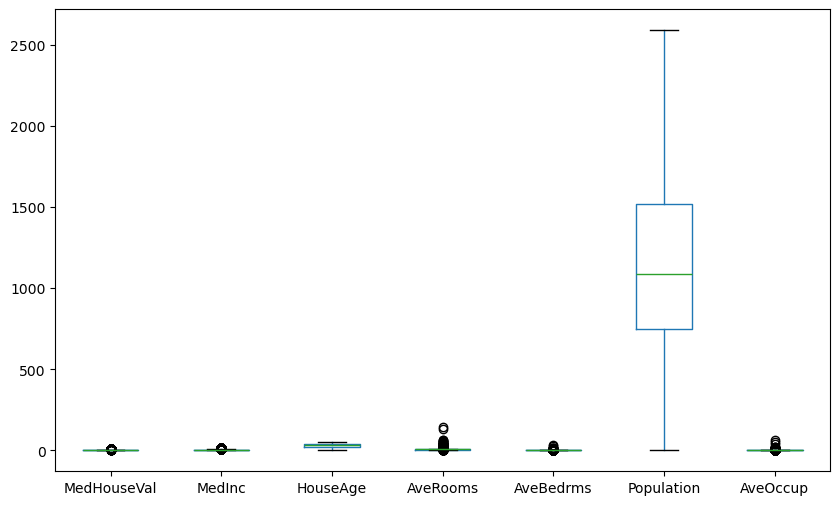

In [48]:
boxplot = df.boxplot(column=['MedHouseVal', 'MedInc', 'HouseAge' ,'AveRooms', 'AveBedrms', 'Population', 'AveOccup'],
                     grid=False, figsize=(10, 6))


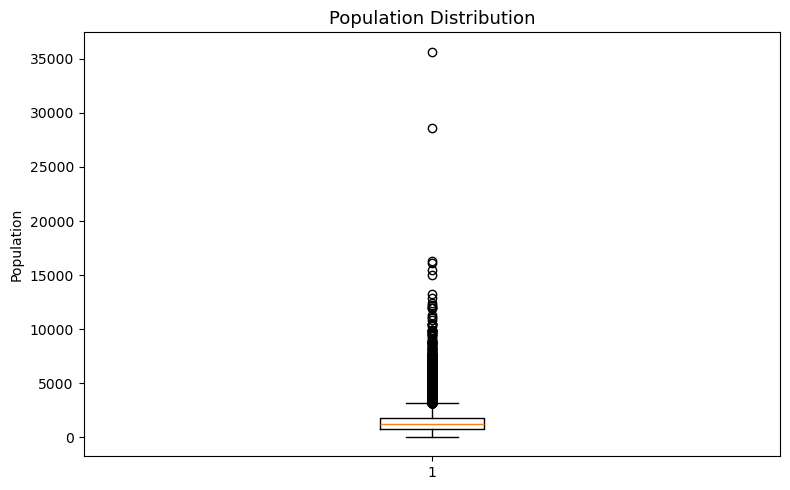

In [ ]:
# explore population outliers
fig, ax = plt.subplots(figsize=(8, 5))

ax.boxplot(df['Population'], vert=True)
ax.set_title('Population Distribution', fontsize=13)
ax.set_ylabel('Population')

plt.tight_layout()
plt.show()

In [72]:
## Limit Population to 95th percentile:
pop_95th = df['Population'].quantile(0.95)
print(f"95th percentile of Population: {pop_95th}")
df = df[df['Population'] <= pop_95th]
print(f"Number of blocks after removing population outliers: {len(df)}")

## Limit Rooms:
df = df[df['AveRooms'] <= 10]
print(f"Number of blocks after removing Room  outliers: {len(df)}")

## Limit Occupancy:
df = df[df['AveOccup'] <= 5]
print(f"Number of blocks after removing occupancy outliers: {len(df)}")

## Limit Bedrroms:
df = df[df['AveBedrms'] <= 2]
print(f"Number of blocks after removing bedroom outliers: {len(df)}")   

## Limit House Values:
df = df[df['MedHouseVal'] <= 5]
print(f"Number of blocks after removing house value outliers: {len(df)}")

95th percentile of Population: 1682.0
Number of blocks after removing population outliers: 14748
Number of blocks after removing Room  outliers: 14748
Number of blocks after removing occupancy outliers: 14748
Number of blocks after removing bedroom outliers: 14748
Number of blocks after removing house value outliers: 13934


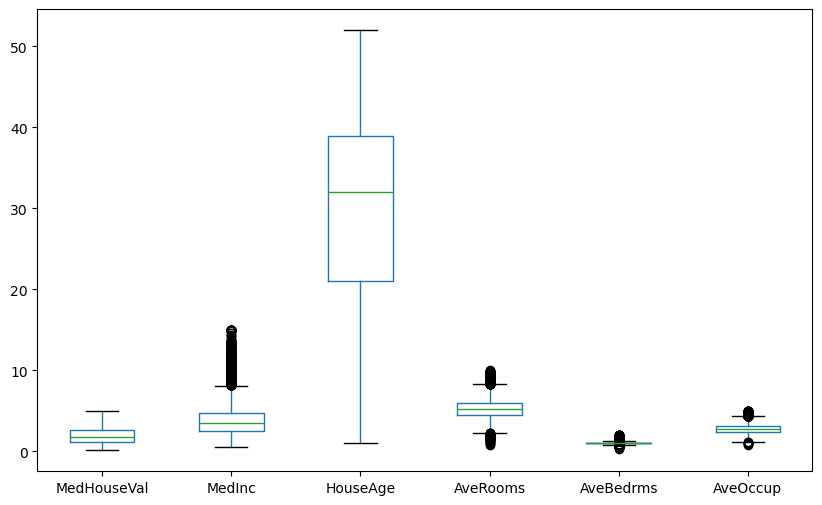

In [66]:
boxplot = df.boxplot(column=['MedHouseVal', 'MedInc', 'HouseAge' ,'AveRooms', 'AveBedrms', 'AveOccup'],
                     grid=False, figsize=(10, 6))


c:\Users\sammi\anaconda3\envs\spatial-regression\Lib\site-packages\matplotlib\axes\_axes.py:7132: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

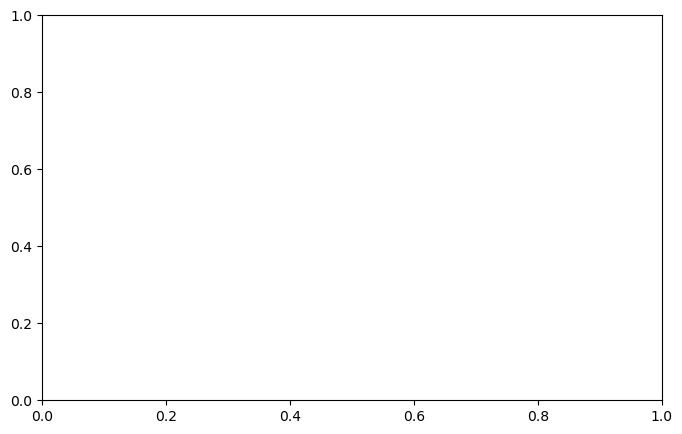

In [ ]:
# explore price outliers
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(df['MedHouseVal'], bins=30, edgecolor='black')
ax.set_title('Median House Value Distribution', fontsize=13)
ax.set_ylabel('Value ($)')

plt.tight_layout()
plt.show()